# Ballistic sedimentation tests

Notes from DA Kring 06/01/21

"The ballistic speed of ejected material traveling over distances that are small relative to the radius of a body can be estimated assuming a planar surface.  The ballistic speed (υ) is then

$υ = \sqrt{\frac{d g}{sin2\theta}}$

where d is the ballistic range, g is gravity (1.624 m/s2 for the Moon), θ is the ejection angle (typically 45°, used here).  The ballistic speed of ejected material traveling 28 to 40 km is 770 to 920 km/hr (0.21 to 0.25 km/s).  Such speeds are too low to produce an explosion or hypervelocity impact crater; typically 3 km/s is needed for the kinetic energy of impact to exceed the internal energy of the impactor, causing an explosive release of energy.  The material might, instead, fragment upon landing and produce a distributed series of rocks.  It might also mechanically excavate a crater, which is not observed.

When the distance is larger, a planar surface approximation is no longer appropriate.  To derive a ballistic formula for a spherical body, we begin with the half-angular distance of travel, φ = R/2Rp, which is related to velocity and the ejection angle (θ) by (Vickery, 1986)

$tan \phi = \frac{v^2 sin \theta cos \theta}{g R_p - v^2 cos^2 \theta}$

where g is again gravity and Rp the Moon’s radius, assuming it is a perfect sphere.  That can be rewritten as

$v = \sqrt{\frac{gR_p tan \phi}{sin \theta cos \theta + cos^2 \theta tan \phi}}$

We utilize an ejection angle of 45°, which is the most probable angle, and noting that the velocity is relatively insensitive to variations of 45 ± 15° (Vickery, 1986).  For Rp = 1737 km, the ballistic speed of debris traveling 400 to 435 km would be 0.76 to 0.79 km/s (2750 to 2860 km/hr).  Those are not hypervelocity speeds, but there would be sufficient kinetic energy to mechanically excavate craters upon landing."

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from moonpies import default_config
from moonpies import moonpies as mp

cfg = default_config.Cfg()

# Constants
G_MOON = 1.624  # [m s^-2]
R_MOON = 1737 * 1e3  # [m]

# Functions
def ballistic_planar(theta, d, g=G_MOON):
    """
    Return ballistic speed (v) given ballistic range (d) and gravity of planet (g).
    
    Assumes planar surface (d << R_planet)
    """
    return np.sqrt((d * g) / np.sin(2 * theta))


def ballistic_spherical(theta, d, g=G_MOON, rp=R_MOON):
    """
    Return ballistic speed (v) given distance of travel (d) and gravity and radius of planet (g, Rp).
    
    Assumes perfectly spherical planet (Vickery, 1986).
    """
    tan_phi = np.tan(d / (2 * rp))
    return np.sqrt(
        (g * rp * tan_phi) / 
        ((np.sin(theta) * np.cos(theta)) + (np.cos(theta)**2 * tan_phi))
    )

def mps2kmph(v):
    """Return v in km/hr, given v in m/s"""
    return 3600. * v / 1000.

def thickness(d, R):
    """Calculate the thickness of an ejecta blanket in meters"""
    return 0.14 * (R**0.74) * ((d/R)**-3.)# pm 0.5

def thick2mass(thick, rho=1500):
    """
    Convert an ejecta blanket thickness to kg per meter squared
    
    Density from Carrier et al. 1991
    """
    return thick * rho

def mps2KE(v, m):
    """Convert ballistic speeds to kinetic energies in joules per meter squared"""
    return 0.5 * m * v**2.


In [2]:
Rad = pd.read_csv(cfg.crater_csv_in)
R = (Rad['Diam (km)']) * 1000. /2.
theta = np.deg2rad(45)
d = np.arange(10, 450) * 1000.  # [m]
thick = np.empty((len(R), len(d)))
v_planar = mps2kmph(ballistic_planar(theta, d))
v_spherical = mps2kmph(ballistic_spherical(theta, d))
for r in range(0,len(R)):
    thick[r, :] = thickness(np.linspace(1.*R[r],4.*R[r],len(d)), R[r])
ke = mps2KE(ballistic_spherical(theta, d), thick2mass(thick))

delT = 272. - 40. #heat from a temperature (here 40 K) to the melting point of water, 272 K
Cp = 4.2 #0.3 kJ/kg/K, heat capacity for regolith, 0.7 to 4.2 kJ/kg/K for H2O

Q = 0.056*0.2*ke / 1000. #kJ / m^2, 0.3-0.1 is the factor of heat not lost by radiation into space (Stopar 2018), 0.056 is the percentage of ice vs regolith (Colaprete2010)
L = 333. #latent heat of ice, kJ / kg
Mice = Q/(L + Cp*delT)


Planar examples:
Ballistic speed at distance 38 km: 894 km/h
Ballistic speed at distance 50 km: 1026 km/h

Spherical examples:
Ballistic speed at distance 410 km: 2784 km/h
Ballistic speed at distance 445 km: 2888 km/h


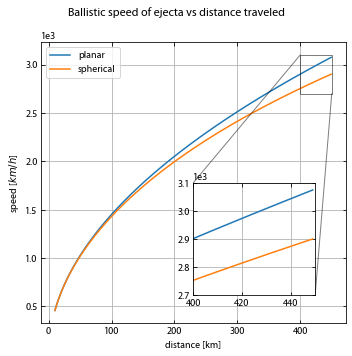

In [3]:
f, ax = plt.subplots(figsize=(5, 5))
f.suptitle('Ballistic speed of ejecta vs distance traveled')

d_km = d / 1000
ax.plot(d_km, v_planar, label='planar')
ax.plot(d_km, v_spherical, label='spherical')

# inset
axins = ax.inset_axes([0.5, 0.1, 0.4, 0.4])
axins.plot(d_km, v_planar, label='planar')
axins.plot(d_km, v_spherical, label='spherical')
x1, x2, y1, y2 = (400, 450, 2700, 3100)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.legend()

ax.set_xlabel('distance [km]')
ax.set_ylabel('speed [$km/h$]')
# plt.savefig("speedvsdistance.png", dpi=300)

# Check values given to us
print('\nPlanar examples:')
for i in (28, 40):
    print(f'Ballistic speed at distance {d_km[i]:.0f} km: {v_planar[i]:.0f} km/h')

print('\nSpherical examples:')
for i in (400, 435):
    print(f'Ballistic speed at distance {d_km[i]:.0f} km: {v_spherical[i]:.0f} km/h')

## Velocity at hummocky terrains (21/11/22)

Oberbeck (1975) Figure 16 shows 4 craters, two < 1 km with no hummocky terrain, but Mosting C (4.2 km) and Harpalus (41.6 km) have hummocky terrain. Kring asked to see the velocity difference of ejecta in either case.

crater d
crater c
Speed (D=4.2, theta=6): 127.71 m/s, 459.75 km/hr
Speed (D=4.2, theta=14): 85.13 m/s, 306.46 km/hr
crater b
Speed (D=0.7, theta=14): 82.67 m/s, 297.60 km/hr
Speed (D=0.7, theta=22): 67.99 m/s, 244.76 km/hr


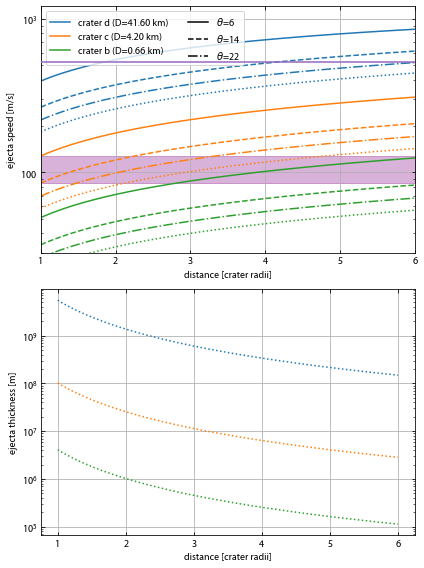

In [4]:
f, axs = plt.subplots(2, figsize=(6, 8))
f.subplots_adjust(hspace=0)
ax = axs[0]
ax2 = axs[1]

d_a = 0.56  # [km]
d_b = 0.66  # [km]
d_c = 4.2  # [km] Mosting C
d_d = 41.6  # [km] Harpalus
diams = (d_d, d_c, d_b, d_a)[:-1]
craters = ('crater d', 'crater c', 'crater b', 'crater a')[:-1]

d_cop = 30.4 * 2
r_crater = np.arange(1, 45)

d_curve = np.arange(0, 45)
v_sph = mps2kmph(ballistic_spherical(theta, d_curve*1000))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ls = ('-', '--', '-.', ':')
thetas = (6, 14, 22, 45)
overlap_zone = []
for i, (d, crater) in enumerate(zip(diams, craters)):
    print(crater)
    for j, theta0 in enumerate(thetas):
        rm = d * 1000/2
        dm = np.linspace(rm, rm*6, 100)
        v = ballistic_spherical(np.deg2rad(theta0), dm)
        t = thickness(dm, rm)
        m = thick2mass(t)
        ke = mps2KE(v, m)
        label = f'{crater} (D={d:.2f} km)' if j == 0 else None
        ax.semilogy(dm/rm, v, ls=ls[j], c=colors[i], label=label)
        if crater == 'crater c' and (theta0 == 6 or theta0 == 14):
            overlap_zone.append(v[0])
            print(f'Speed (D={d:.1f}, theta={theta0}): {v[0]:.2f} m/s, {mps2kmph(v[0]):.2f} km/hr')
        elif crater == 'crater b' and (theta0 == 14 or theta0 == 22):
            print(f'Speed (D={d:.1f}, theta={theta0}): {v[-1]:.2f} m/s, {mps2kmph(v[-1]):.2f} km/hr')
    # ax2.semilogy(dm/rm, t, ':', c=colors[i])
    ax2.semilogy(dm/rm, ke, ':', c=colors[i])
    # print(f'Crater D={d:4.1f} km; Speed={v:.1f} m/s; KE={ke/1e6:.2f} MJ')

# Overlap zone
ax.fill_between(dm/rm, [overlap_zone[1]]*len(dm), [overlap_zone[0]]*len(dm), color='purple', alpha=0.3)

ax.axhline(520, ls='-', c='tab:purple', zorder=10)

# theta labels
for j in range(3):
    ax.plot([0,0.1], [101, 102], ls=ls[j], c='k', label=f'$\\theta$={thetas[j]}')

ax.legend(ncol=2)
ax.set_xlim(1, 6)
ax.set_ylim(30, 1200)
ax.set_xlabel('distance [crater radii]')
ax2.set_xlabel('distance [crater radii]')
ax.set_ylabel('ejecta speed [m/s]')
ax2.set_ylabel('ejecta thickness [m]')
plt.show()

/tmp/ipykernel_996/529960918.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('/home/cjtu/projects/moonpies/figures/ballistic_kinetic_energy.png', dpi=300)
/home/cjtu/projects/moonpies/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


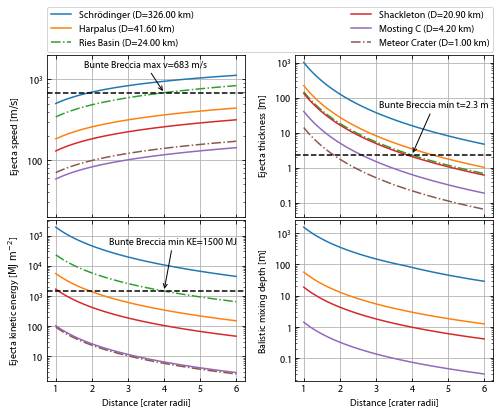

In [69]:
f, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, gridspec_kw={'wspace':0.25, 'hspace':0.02})
# f.tight_layout()
# f.subplots_adjust(wspace=0, hspace=0)
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

c_d = {
    "Schrödinger": 326,
    "Harpalus": 41.6,  # Harpalus (Oberbeck d)
    "Ries Basin": 24,
    "Shackleton": 20.9,  # smallest polar
    "Mosting C": 4.2,  # Mosting C (Oberbeck c)
    "Meteor Crater": 1, 
    # "Oberbeck b": 0.66,
    # "crater a": 0.56,
}
# ries_max_obs = 36.5  # [km]
ries_max_obs = c_d['Ries Basin']*2  # [km]

craters, diams = zip(*c_d.items())

d_cop = 30.4 * 2
r_crater = np.arange(1, 45)

d_curve = np.arange(0, 45)
v_sph = mps2kmph(ballistic_spherical(theta, d_curve*1000))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ls = '-'
theta0 = 45
overlap_zone = []
for i, (d, crater) in enumerate(zip(diams, craters)):
    terrestrial = crater == 'Ries Basin' or crater == 'Meteor Crater'
    ls = '-'
    rm = d * 1000/2  # radius [m]
    dm = np.linspace(rm, rm*6, 100)  # dist [m]
    t = thickness(dm, rm)  # thickness at 1 crater radius [m]
    v = ballistic_spherical(np.deg2rad(theta0), dm)  # speed [m/s]
    m = thick2mass(t)  # mass [kg]
    mr = mp.get_mixing_ratio_oberbeck(dm)  # mixing ratio
    depth = t * mr  # depth [m]
    if terrestrial:
        # Use earth values for Ries and Meteor (affects speed and mass)
        ls = '-.'
        v = ballistic_spherical(np.deg2rad(theta0), dm, 9.81, 6371e3)
        m = thick2mass(t, 2700)
    ke = mps2KE(v, m)/1e6  # kinetic energy [MJ]
    if crater == 'Ries Basin':
        idx = np.argmin(np.abs(dm - ries_max_obs*1e3))
        ries_v = v[idx]
        ries_t = t[idx]
        ries_ke = ke[idx]
        ries_depth = depth[idx]

    label = f'{crater} (D={d:.2f} km)'
    ax1.semilogy(dm/rm, v, ls=ls, c=colors[i], label=label)
    ax2.semilogy(dm/rm, t, ls=ls, c=colors[i], label=label)
    ax3.semilogy(dm/rm, ke, ls=ls, c=colors[i], label=label)
    if not terrestrial:
        ax4.semilogy(dm/rm, depth, ls=ls, c=colors[i], label=label)

# Ries bsed zone
ax1.axhline(ries_v, ls='--', c='k')
ax1.annotate(f'Bunte Breccia max v={ries_v:.0f} m/s', (4, ries_v), xytext=(3.5, 1400), ha='center', arrowprops=dict(arrowstyle="->"))
ax2.axhline(ries_t, ls='--', c='k')
ax2.annotate(f'Bunte Breccia min t={ries_t:.1f} m', (4, ries_t), xytext=(4.6, 50), ha='center', arrowprops=dict(arrowstyle="->"))
ax3.axhline(ries_ke, ls='--', c='k')
ax3.annotate(f'Bunte Breccia min KE={round(ries_ke,-2):.0f} MJ', (4, ries_ke), xytext=(4.25, 5e4), ha='center', arrowprops=dict(arrowstyle="->"))
# ax4.axhline(ries_depth, ls='--', c='k', label=f'Bunte Breccia min depth={ries_depth:.0f} m')

ax1.legend(bbox_to_anchor=(0., 1.02, 2.25, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# for ax in axs.flatten():
#     ax.legend(bbox_to_anchor=(1, 1))
#     ax.set_xlim(1, 6)
ax1.set_ylim(20, 2000)

ax1.set_ylabel('Ejecta speed [$\\rm m/s$]')
ax2.set_ylabel('Ejecta thickness [$\\rm m$]')
ax3.set_ylabel('Ejecta kinetic energy [$\\rm MJ \\ m^{-2}$]')
ax4.set_ylabel('Balistic mixing depth [$\\rm m$]')
ax3.set_xlabel('Distance [crater radii]')
ax4.set_xlabel('Distance [crater radii]')
plt.savefig('/home/cjtu/projects/moonpies/figures/ballistic_kinetic_energy.png', dpi=300)
plt.show()

In [ ]:
cfg_warm = default_config.Cfg(temp_depth_profile = 'warm')
cfg_cold = default_config.Cfg(temp_depth_profile = 'cold')
depth = np.arange(0, 30)
t_warm = mp.temp_at_depth(depth*1000, cfg_warm)
t_cold = mp.temp_at_depth(depth*1000, cfg_cold)

plt.plot(depth, t_warm, label='warm')
plt.plot(depth, t_cold, label='cold')
plt.legend()
plt.xlabel('depth [km]')
plt.ylabel('temperature [K]')

print('D_warm', depth[np.argmin(np.abs(t_warm - 390))])
print('D_cold', depth[np.argmin(np.abs(t_cold - 268))])
plt.show()

TypeError: __init__() got an unexpected keyword argument 'temp_depth_profile'

850.0


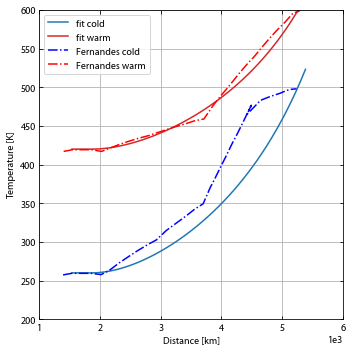

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
d_imb = 769 # [km]
dist = np.linspace(d_imb*2, d_imb*7)
dist_crad = dist / (d_imb/2)
v = ballistic_spherical(np.deg2rad(45), dist*1000)
t = mp.get_ejecta_thickness(dist*1000, d_imb*1000/2, order=-3)
mass = t * cfg.target_density
v_excess = v - 1.45e3
v_excess[v_excess < 0] = 0
ke = mp.kinetic_energy(mass, v_excess)
t0 = mp.temp_at_depth(60*1e3)
print(t0)
heat_frac = 0.45
cp_260 = 693.06
cp_420 = 928.06
del_t_cold = mp.delta_temp_at_impact(ke, mass, heat_frac, cp_260)
del_t_warm = mp.delta_temp_at_impact(ke, mass, heat_frac, cp_420)

# t = thickness(dist*1000, d_imb*1000/2)  # thickness at 1 crater radius
# t_warm = 1000*4.2*(dist_crad)**-3.6  # isale thickness warm [m]
# t_cold = 1000*3*(dist_crad)**-2.9  # isale thickness cold [m]
ax.plot(dist, 260+del_t_cold, c='tab:blue', label='fit cold')
ax.plot(dist, 420+del_t_warm, c='tab:red', label='fit warm')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Temperature [K]')
ax.set_xlim(1000, 6000)
ax.set_ylim(200, 600)
# plt.loglog(dist_crad, t, label='ej thick')
# plt.loglog(dist_crad, t_warm, label='warm')
# plt.loglog(dist_crad, t_cold, label='cold')
# plt.legend()
actual_cold = pd.read_csv('/home/cjtu/Downloads/fernandes_cold.csv', header=None)
actual_warm = pd.read_csv('/home/cjtu/Downloads/fernandes_warm.csv', header=None)
ax.plot(actual_cold[0], actual_cold[1], 'b-.', label='Fernandes cold')
ax.plot(actual_warm[0], actual_warm[1], 'r-.', label='Fernandes warm')
ax.legend()
plt.show()

In [ ]:
actual_warm.iloc[:5, 1]

0    417.065448
1    419.227483
2    419.241576
3    419.241576
4    417.062283
Name: 1, dtype: float64

## Robbins database crater stats

In [ ]:
sdf = pd.read_csv('/home/cjtu/projects/moonpies/data/out/lunar_crater_database_robbins_2018.csv')
sdf.head()

,CRATER_ID,LAT_CIRC_IMG,LON_CIRC_IMG,LAT_ELLI_IMG,LON_ELLI_IMG,DIAM_CIRC_IMG,DIAM_CIRC_SD_IMG,DIAM_ELLI_MAJOR_IMG,DIAM_ELLI_MINOR_IMG,DIAM_ELLI_ECCEN_IMG,...,DIAM_ELLI_ANGLE_IMG,LAT_ELLI_SD_IMG,LON_ELLI_SD_IMG,DIAM_ELLI_MAJOR_SD_IMG,DIAM_ELLI_MINOR_SD_IMG,DIAM_ELLI_ANGLE_SD_IMG,DIAM_ELLI_ECCEN_SD_IMG,DIAM_ELLI_ELLIP_SD_IMG,ARC_IMG,PTS_RIM_IMG
0,00-1-000000,-19.83040,264.7570,-19.89050,264.6650,940.960,21.31790,975.874,905.968,0.371666,...,35.9919,0.007888,0.008424,0.636750,0.560417,0.373749,0.002085,0.000968,0.568712,8088
1,00-1-000001,44.77630,328.6020,44.40830,329.0460,249.840,5.99621,289.440,245.786,0.528111,...,127.0030,0.011178,0.015101,1.052780,0.209035,0.357296,0.005100,0.004399,0.627328,2785
2,00-1-000002,57.08660,82.0995,56.90000,81.6464,599.778,21.57900,632.571,561.435,0.460721,...,149.1620,0.008464,0.019515,0.776149,0.747352,0.374057,0.003095,0.002040,0.492373,5199
3,00-1-000003,1.96124,230.6220,1.95072,230.5880,558.762,14.18190,568.529,546.378,0.276416,...,133.6910,0.007079,0.007839,0.526945,0.532872,1.262710,0.004496,0.001400,0.595221,4341
4,00-1-000004,-49.14960,266.3470,-49.18330,266.3530,654.332,17.50970,665.240,636.578,0.290365,...,87.6468,0.008827,0.017733,0.568958,0.758631,1.383530,0.004626,0.001533,0.545924,5933


In [ ]:
cdf = pd.read_csv(cfg.crater_csv_in)
polar = sdf[sdf.LAT_CIRC_IMG < -84]
dmin = cdf['Diam (km)'].min()
dmax = cdf['Diam (km)'].max()
print(len(polar))
polar.groupby(pd.cut(polar.DIAM_CIRC_IMG, [1, 2, 4, 20, 300])).DIAM_CIRC_IMG.count()

5249


DIAM_CIRC_IMG
(1, 2]       3242
(2, 4]       1443
(4, 20]       536
(20, 300]      28
Name: DIAM_CIRC_IMG, dtype: int64

TypeError: object of type 'int' has no len()

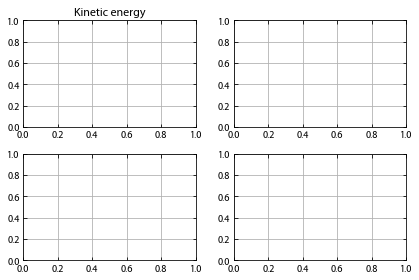

In [ ]:
f2, axs = plt.subplots(2,2)#,figsize=(5, 5))
axs[0,0].set_title('Kinetic energy')
d_km = d / 1000
for i in range(0,len(R)):
    axs[0,0].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/1000., ke[i,:], label='Kinetic Energy')
axs[0,0].set_xlabel('distance [km]')
axs[0,0].set_ylabel('kinetic energy [$J/m^{2}$]')
axs[0,0].grid(True, which="both")

axs[0,1].set_title('Thickness')
for i in range(0,len(R)):
    axs[0,1].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/1000., thick[i,:], label='Thickness')
axs[0,1].set_xlabel('distance [km]')
axs[0,1].set_ylabel('thickness [$m$]')
axs[0,1].grid(True, which="both")

axs[1,0].set_title('Mass Melted')
for i in range(0,len(R)):
    axs[1,0].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/1000., Mice[i,:], label='Mass of ice melted per meter squared')
axs[1,0].set_xlabel('distance [km]')
axs[1,0].set_ylabel('mass melted [$kg / m^{2}$]')
axs[1,0].grid(True, which="both")

axs[1,1].set_title('Depth Melted')
for i in range(0,len(R)):
    axs[1,1].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/1000., Mice[i,:]/180., label='Depth of ice melted')
axs[1,1].set_xlabel('distance [km]')
axs[1,1].set_ylabel('depth melted [$m$]')
axs[1,1].grid(True, which="both")
plt.tight_layout()
plt.savefig("Distance_ejecta.png")

#f6, ax6 = plt.subplots(figsize=(5, 5))
#f6.suptitle('Ballistic speed of ejecta vs distance traveled')
#ax6.plot(d_km, v_spherical, label='Ballistic Speed')
#ax6.set_xlabel('distance [km]')
#ax6.set_ylabel('speed [$km/h$]')


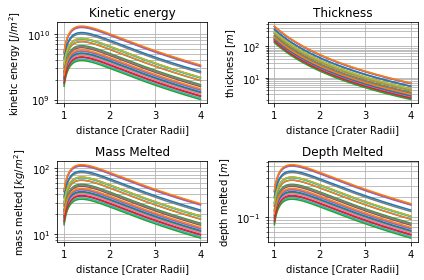

In [ ]:
f3, axs = plt.subplots(2,2)#,figsize=(5, 5))
axs[0,0].set_title('Kinetic energy')

d_km = d / 1000
for i in range(0,len(R)):
    axs[0,0].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/R[i], ke[i,:], label='Kinetic Energy')
axs[0,0].set_xlabel('distance [Crater Radii]')
axs[0,0].set_ylabel('kinetic energy [$J/m^{2}$]')
axs[0,0].grid(True, which="both")

axs[0,1].set_title('Thickness')
for i in range(0,len(R)):
    axs[0,1].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/R[i], thick[i,:], label='Thickness')
axs[0,1].set_xlabel('distance [Crater Radii]')
axs[0,1].set_ylabel('thickness [$m$]')
axs[0,1].grid(True, which="both")

axs[1,0].set_title('Mass Melted')
for i in range(0,len(R)):
    axs[1,0].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/R[i], Mice[i,:], label='Mass of ice melted per meter squared')
axs[1,0].set_xlabel('distance [Crater Radii]')
axs[1,0].set_ylabel('mass melted [$kg / m^{2}$]')
axs[1,0].grid(True, which="both")

axs[1,1].set_title('Depth Melted')
for i in range(0,len(R)):
    axs[1,1].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/R[i], Mice[i,:]/180., label='Depth of ice melted')
axs[1,1].set_xlabel('distance [Crater Radii]')
axs[1,1].set_ylabel('depth melted [$m$]')
axs[1,1].grid(True, which="both")
plt.tight_layout()
plt.savefig("Distance_ejecta_R.png")